# Data preparation and feature engineering 

In [1]:
# libraries 
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler

## Loading data and cleaning    

In [2]:
df_cal = pd.read_csv("C:/Users/Kiwi/OneDrive - Kruvelab/Yvonne/02_courses/UT machine learning/project work/data_ready_231029.csv")

df_cal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3938 entries, 0 to 3937
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   lab          3938 non-null   object 
 1   compound     3938 non-null   object 
 2   sample_type  3938 non-null   object 
 3   RT           3932 non-null   float64
 4   sample       3938 non-null   object 
 5   peak_area    3938 non-null   float64
 6   note         3938 non-null   object 
 7   c_real_M     3932 non-null   float64
dtypes: float64(3), object(5)
memory usage: 246.3+ KB


In [3]:
df_cal.dropna(subset=['c_real_M'], inplace=True) # drops 6 rows
df_cal.dropna(subset=['RT'], inplace=True) # drops 4 rows

# Filter the DataFrame to exclude rows with compounds having only one or 2 entries
compound_counts = df_cal.groupby(['lab', 'compound']).size()
groups_to_keep = compound_counts[compound_counts > 2].index
df_cal = df_cal[df_cal.set_index(['lab', 'compound']).index.isin(groups_to_keep)]

df_cal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3860 entries, 0 to 3937
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   lab          3860 non-null   object 
 1   compound     3860 non-null   object 
 2   sample_type  3860 non-null   object 
 3   RT           3860 non-null   float64
 4   sample       3860 non-null   object 
 5   peak_area    3860 non-null   float64
 6   note         3860 non-null   object 
 7   c_real_M     3860 non-null   float64
dtypes: float64(3), object(5)
memory usage: 271.4+ KB


## Feature engineering  

### Response factor features

In [4]:
# add response factor and response factor error
df_cal['rf'] = df_cal['peak_area'] / df_cal['c_real_M']
df_cal['rf_error'] = abs(df_cal['rf'] - df_cal.groupby(['lab', 'compound'])['rf'].transform('mean'))


### Linear regression features

In [5]:
from sklearn.linear_model import LinearRegression

df_cal['slope'] = 0.0
df_cal['intercept'] = 0.0
df_cal['residuals'] = 0.0
df_cal['abs_residuals'] = 0.0

# do linear regression for each group and add features
for (lab, compound), group in df_cal.groupby(['lab', 'compound']):
    X = group[['c_real_M']]
    y = group['peak_area']

    model = LinearRegression()
    model.fit(X, y)

    df_cal.loc[group.index, 'slope'] = model.coef_[0]
    df_cal.loc[group.index, 'intercept'] = model.intercept_
    df_cal.loc[group.index, 'residuals'] = y - model.predict(X)
    df_cal.loc[group.index, 'abs_residuals'] = abs(y - model.predict(X))

print(df_cal.columns.values)
df_cal.info(verbose=True)


['lab' 'compound' 'sample_type' 'RT' 'sample' 'peak_area' 'note'
 'c_real_M' 'rf' 'rf_error' 'slope' 'intercept' 'residuals'
 'abs_residuals']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3860 entries, 0 to 3937
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lab            3860 non-null   object 
 1   compound       3860 non-null   object 
 2   sample_type    3860 non-null   object 
 3   RT             3860 non-null   float64
 4   sample         3860 non-null   object 
 5   peak_area      3860 non-null   float64
 6   note           3860 non-null   object 
 7   c_real_M       3860 non-null   float64
 8   rf             3860 non-null   float64
 9   rf_error       3860 non-null   float64
 10  slope          3860 non-null   float64
 11  intercept      3860 non-null   float64
 12  residuals      3860 non-null   float64
 13  abs_residuals  3860 non-null   float64
dtypes: float64(9), object(5)
memory usage: 58

### Feature normalisation

In general we decided to try out two different normalisation strategies:

**norm1**
$$
\text{norm1} = \frac{\text{x}}{\max(\text{x})}
$$

**norm2**
$$
\text{norm2} = \frac{\text{x} - \min(\text{x})}{\max(\text{x}) - \min(\text{x})}
$$

#### Normalisation strategy 1

In [6]:
df_cal['peak_area_norm1'] = df_cal.groupby(['lab', 'compound'])['peak_area'].transform(lambda x: x / x.max())
df_cal['c_real_M_norm1'] = df_cal.groupby(['lab', 'compound'])['c_real_M'].transform(lambda x: x / x.max())
df_cal['rf_norm1'] = df_cal.groupby(['lab', 'compound'])['rf'].transform(lambda x: x / x.max())
df_cal['rf_error_norm1'] = df_cal.groupby(['lab', 'compound'])['rf_error'].transform(lambda x: x / x.max())
df_cal['residuals_norm1'] = df_cal.groupby(['lab', 'compound'])['residuals'].transform(lambda x: x / x.max())
df_cal['abs_residuals_norm1'] = df_cal.groupby(['lab', 'compound'])['abs_residuals'].transform(lambda x: x / x.max())

df_cal.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3860 entries, 0 to 3937
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   lab                  3860 non-null   object 
 1   compound             3860 non-null   object 
 2   sample_type          3860 non-null   object 
 3   RT                   3860 non-null   float64
 4   sample               3860 non-null   object 
 5   peak_area            3860 non-null   float64
 6   note                 3860 non-null   object 
 7   c_real_M             3860 non-null   float64
 8   rf                   3860 non-null   float64
 9   rf_error             3860 non-null   float64
 10  slope                3860 non-null   float64
 11  intercept            3860 non-null   float64
 12  residuals            3860 non-null   float64
 13  abs_residuals        3860 non-null   float64
 14  peak_area_norm1      3860 non-null   float64
 15  c_real_M_norm1       3860 non-null   f

#### Normalisation strategy 2


In [7]:
from sklearn.preprocessing import MinMaxScaler

columns_to_scale = ['peak_area', 'c_real_M', 'rf', 'rf_error', 'residuals', 'abs_residuals']

scaler = MinMaxScaler()

def scale_columns(group):
    for col in columns_to_scale:
        group[f'{col}_norm2'] = scaler.fit_transform(group[[col]])
    return group


df_cal = df_cal.groupby(['lab', 'compound']).apply(scale_columns)


C:\Users\Kiwi\AppData\Local\Temp\ipykernel_16852\1920144247.py:13: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_cal = df_cal.groupby(['lab', 'compound']).apply(scale_columns)


In [8]:
df_cal.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3860 entries, 0 to 3937
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   lab                  3860 non-null   object 
 1   compound             3860 non-null   object 
 2   sample_type          3860 non-null   object 
 3   RT                   3860 non-null   float64
 4   sample               3860 non-null   object 
 5   peak_area            3860 non-null   float64
 6   note                 3860 non-null   object 
 7   c_real_M             3860 non-null   float64
 8   rf                   3860 non-null   float64
 9   rf_error             3860 non-null   float64
 10  slope                3860 non-null   float64
 11  intercept            3860 non-null   float64
 12  residuals            3860 non-null   float64
 13  abs_residuals        3860 non-null   float64
 14  peak_area_norm1      3860 non-null   float64
 15  c_real_M_norm1       3860 non-null   f

C:\Users\Kiwi\AppData\Local\Temp\ipykernel_16852\2276188068.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  df_cal.info(verbose=True, null_counts=True)


## save out data frame 

In [10]:
folder_path = 'C:/Users/Kiwi/OneDrive - Kruvelab/Yvonne/02_courses/UT machine learning/project work'
file_name = 'data_ready_addfeatures_231122.csv'

file_path = f'{folder_path}/{file_name}'

df_cal.to_csv(file_path, index=False)


## Feature visualisation 

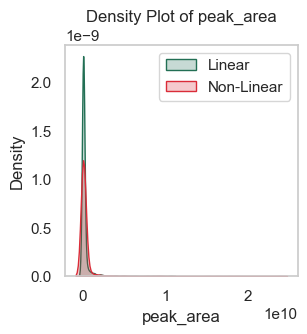

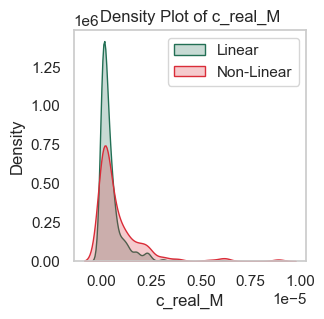

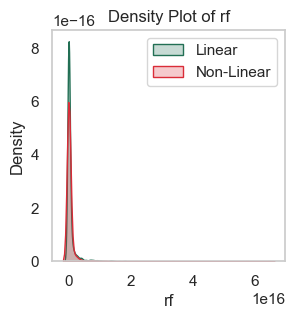

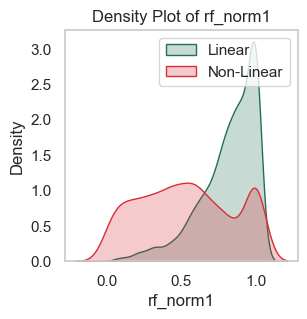

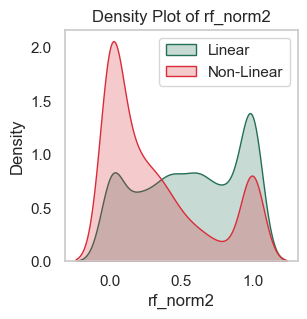

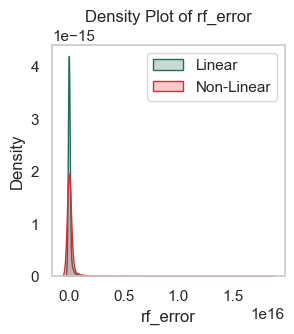

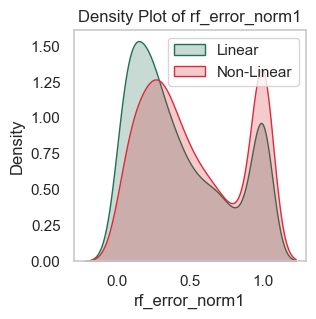

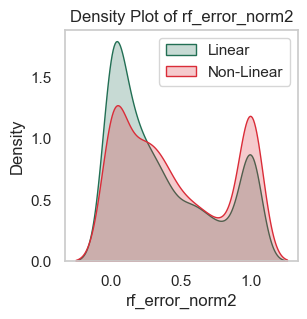

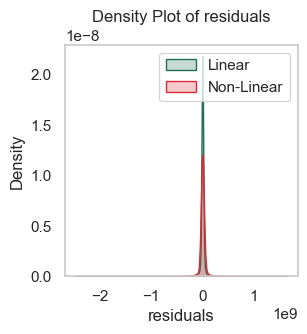

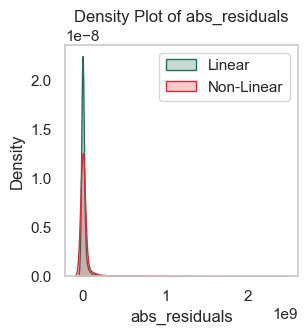

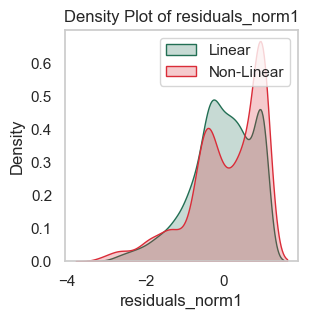

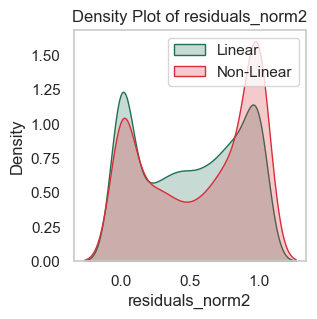

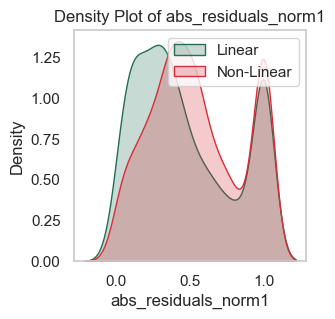

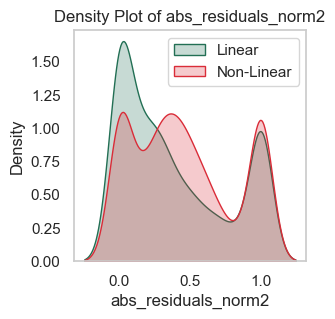

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


columns_to_plot = ['peak_area', 'c_real_M', 'rf', 'rf_norm1', 'rf_norm2',
                   'rf_error', 'rf_error_norm1', 'rf_error_norm2',
                   'residuals', 'abs_residuals',
                   'residuals_norm1', 'residuals_norm2',
                   'abs_residuals_norm1','abs_residuals_norm2']


sns.set(style="whitegrid")
colors = {'linear': '#226f54', 'non-linear': '#da2c38'}


for column in columns_to_plot:
    plt.figure(figsize=(3,3))
    
    # Plot density functions colored by 'note'
    # sns.kdeplot(data=df_cal, x=column, hue='note', fill=True, common_norm=False)
    sns.kdeplot(data=df_cal, x=column, hue='note', fill=True, common_norm=False,
                palette=colors)
    plt.legend(labels=['Linear', 'Non-Linear'], loc='upper right')
    plt.grid(False)
    plt.title(f'Density Plot of {column}')
    
    plt.show()